<a href="https://colab.research.google.com/github/DaniilSysoev/opisis_sem_12/blob/main/%D0%9E%D0%BF%D0%B8%D1%81%D0%B8%D1%81_%D1%81%D0%B5%D0%BC_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Дифференциальные системы. Развязывающие устройства на дифференциальных системах. Имитация работы системы двусторонней связи по однополосной двухпроводной схеме.</h1>

<h2>С помощью программы, приложенной в материалах к данному занятию, представить графики распределения напряжений в линиях передачи в зависимости от времени и от длины системы (для тех случаев, где это предусмотрено), а также спектры этих сигналов для различных значений параметра неравноплечности развязывающих устройств на РДС.</h2>

<h3>Проведем вычисления для параметра неравноплечности равного 1</h3>

Временной интервал 10
Характеристическое сопротивление одного звена ЛП на частоте 20.0 600
Число ячеек в ЛП 20
Параметр неравноплечности РУ 1
Параметры отдельной ячейки ЛП:
C1 =  0.000002
C2 =  0.018922
L =  1.338676
Затухание в направлении передачи:  6.02 дБ -  2.00
Затухание в направлении приема:  6.02 дБ -  2.00
dpp =  20
  0.000   0.000   0.000 
  0.500  -0.182  -0.182 
  1.000  -0.371  -0.371 
  1.500  -0.379  -0.379 
  2.000  -0.379  -0.379 
  2.500  -0.379  -0.379 
  3.000  -0.379  -0.379 
  3.500  -0.379  -0.379 
  4.000  -0.379  -0.379 
  4.500  -0.379  -0.379 
  5.000  -0.379  -0.379 
  5.500  -0.379  -0.379 
  6.000  -0.379  -0.379 
  6.500  -0.379  -0.379 
  7.000  -0.379  -0.379 
  7.500  -0.379  -0.379 
  8.000  -0.379  -0.379 
  8.500  -0.379  -0.379 
  9.000  -0.379  -0.379 
  9.500  -0.379  -0.379 


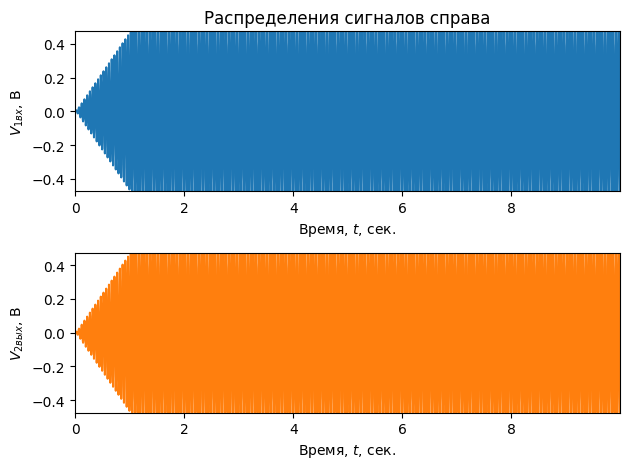

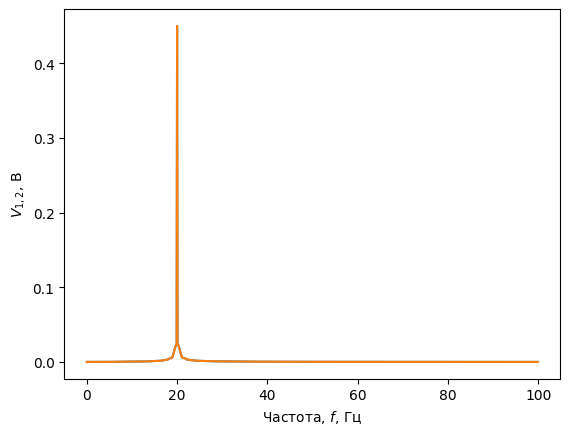

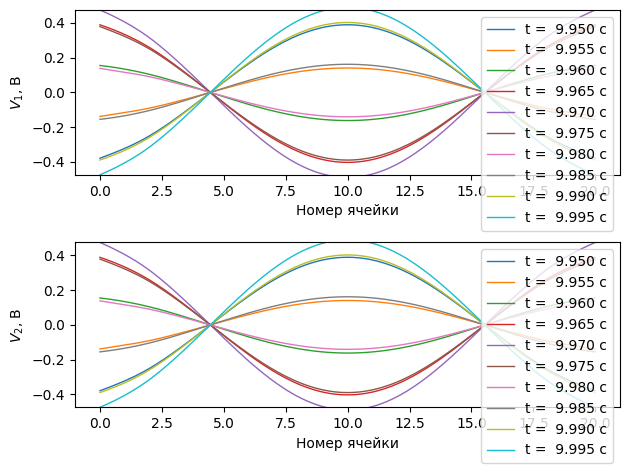

  0.000  -0.379  -0.379 
  0.500  -0.602  -0.546 
  1.000  -0.721  -0.617 
  1.500  -0.721  -0.625 
  2.000  -0.721  -0.624 
  2.500  -0.721  -0.625 
  3.000  -0.721  -0.625 
  3.500  -0.721  -0.625 
  4.000  -0.721  -0.625 
  4.500  -0.721  -0.625 
  5.000  -0.721  -0.625 
  5.500  -0.721  -0.625 
  6.000  -0.721  -0.625 
  6.500  -0.721  -0.625 
  7.000  -0.721  -0.625 
  7.500  -0.721  -0.625 
  8.000  -0.721  -0.625 
  8.500  -0.721  -0.625 
  9.000  -0.721  -0.625 
  9.500  -0.721  -0.625 


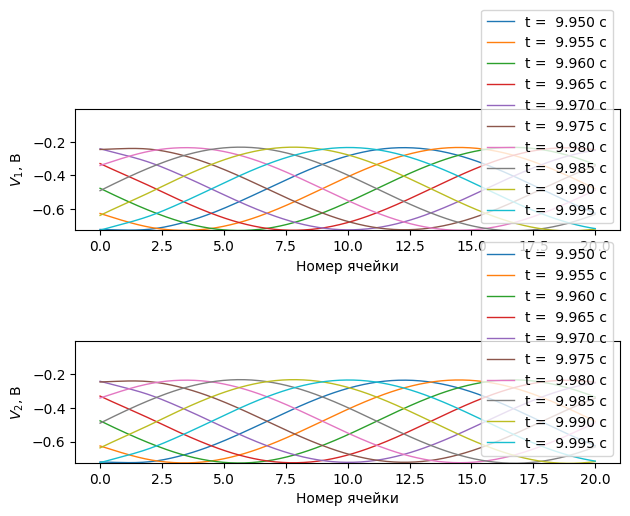

In [ ]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline


# Гармонический сигнал слева
def signal1(t):
    coef = 1 if t > 1 else 0.5 * t ** 2
    return -coef * cos(2.0 * pi * fc1 * t)


# Производная гармонического сигнала слева
def d_signal1(t):
    coef = 1 if t > 1 else t
    return 2.0 * pi * fc1 * coef * sin(2.0 * pi * fc1 * t)


# Гармонический сигнал справа
def signal2(t):
    coef = 1 if t > 1 else 0.5 * t ** 2
    return -coef * cos(2.0 * pi * fc2 * t)


# Производная гармонического сигнала справа
def d_signal2(t):
    coef = 1 if t > 1 else t
    return 2.0 * pi * fc2 * coef * sin(2.0 * pi * fc2 * t)


# Широкополосный импульс
def wb_pulse(t, fn, fv):
    freq = (fv + fn) * 0.5
    dt = 1.0 / (fv - fn)
    return exp(-(0.5 * Tc - t) ** 2 / dt ** 2 * 0.5) * sin(2.0 * pi * freq * t)


# Производная широкополосного импульса
def d_wb_pulse(t, fn, fv):
    freq = (fv + fn) * 0.5
    dt = 1.0 / (fv - fn)
    a1 = 2.0 * pi * freq * t * exp(-(0.5 * Tc - t) ** 2 / dt ** 2 * 0.5) * cos(2.0 * pi * freq * t)
    a2 = -2.0 * t / (2.0 * dt ** 2) * exp(-(0.5 * Tc - t) ** 2 / dt ** 2 * 0.5) * sin(2.0 * pi * freq * t)
    return a1 + a2


# Перевод частоты в циклическую
def f2w(f):
    return 2.0 * pi * f


pulse_1 = False  # False - гармонический сигнал True - ШП импульс для абонента 1 (слева)
pulse_2 = False   # False - гармонический сигнал True - ШП импульс для абонента 2 (справа)
one_ds = False  # Одна РДС (слева), иначе РДС слева и справа

fc1 = 20  # Частота сигнала левого абонента
fc2 = fc1  # Частота сигнала правого абонента
Tc = float(input('Временной интервал '))

fl = 1  # float(input('Нижняя граничная частота ЛП '))
fh = 100  # float(input('Верхняя граничная частота ЛП '))
f0 = (fc1 + fc2) * 0.5  # (fl + fh) * 0.5
Z0 = float(input('Характеристическое сопротивление одного звена ЛП на частоте ' + str(f0) + ' '))
Nc = int(input('Число ячеек в ЛП '))
Ha = float(input('Параметр неравноплечности РУ '))

A12 = 20 * log10(1.0 + 1.0 / Ha)
A14 = 20 * log10(1.0 + Ha)

L = (sqrt(Z0 ** 2 * f2w(f0) ** 2 * (2 * f2w(fh) ** 2 - f2w(fl) ** 2 - f2w(f0) ** 2) /
          ((f2w(fh) ** 2 - f2w(fl) ** 2) ** 2 * (f2w(f0) ** 2 - f2w(fl) ** 2))))
C1 = 1.0 / L / (f2w(fh) ** 2 - f2w(fl) ** 2)
C2 = 1.0 / (f2w(fl) ** 2 * L)
G = 0

print('Параметры отдельной ячейки ЛП:')
print('C1 = {0: f}\nC2 = {1: f}\nL = {2: f}'.format(C1, C2, L))
print('Затухание в направлении передачи: {0: 5.2f} дБ - {1: 5.2f}'.format(A12, 10 ** (0.05 * A12)))
print('Затухание в направлении приема: {0: 5.2f} дБ - {1: 5.2f}'.format(A14, 10 ** (0.05 * A14)))

npp = 10  # Количество точек на период гармонического сигнала
dt = 1 / (max(fc1, fc2) * npp)  # Шаг по времени
num = int(Tc / dt)  # Количество временных отсчетов

freq = np.linspace(0.8 * fl, fh * 1.2, num)

A0 = 1  # Амплитуда сигнала в направлении слева направо
AN = 1  # Амплитуда сигнала в направлении справа налево
K0 = KN = 1  # Коэффициенты при нагрузочных сопротивлениях

# Количество итераций для решения уравнений возбуждения
dpp = 20
print('dpp = {0: d}'.format(dpp))

aU_1 = [0] * Nc  # Массив напряжений на емкости C2
aU_2 = [0] * Nc  # Массив напряжений на емкости C2
dU_1 = [0] * Nc  # Массив производных напряжений на емкости C2
dU_2 = [0] * Nc  # Массив производных напряжений на емкости C2
aV_1 = [0] * (Nc + 1)  # Массив напряжений на емкости C1
aV_2 = [0] * (Nc + 1)  # Массив напряжений на емкости C1
dV_1 = [0] * (Nc + 1)  # Массив производных напряжений на емкости C1
dV_2 = [0] * (Nc + 1)  # Массив производных напряжений на емкости C1

Vinp_1 = [0] * num  # Массив входных напряжений
Vinp_2 = [0] * num  # Массив входных напряжений
Vout_1 = [0] * num  # Массив выходных напряжений
Vout_2 = [0] * num  # Массив выходных напряжений
time = [0] * num  # Массив временных отсчетов

Vs_1 = [0] * npp  # Массив напряжений на C1 вдоль ЛП на одном периоде сигнала
Vs_2 = [0] * npp  # Массив напряжений на C1 вдоль ЛП на одном периоде сигнала
for i in range(npp):
    Vs_1[i] = [0] * (Nc + 1)
    Vs_2[i] = [0] * (Nc + 1)

vmax = vmin = 0
# Решение уравнений возбуждения ЛП
for it in range(num):
    time[it] = dt * it
    for i in range(dpp):
        dE0_1 = A0 / (10 ** (0.05 * A12)) * (d_wb_pulse(time[it], 10, 20) if pulse_1 else d_signal1(time[it]))
        dE0_2 = A0 / (10 ** (0.05 * A14)) * (d_wb_pulse(time[it], 10, 20) if pulse_1 else d_signal1(time[it]))
        dV_1[0] += (1.0 / (L * C1) * (aV_1[1] - aV_1[0] + aU_1[0]) + 1.0 / (Z0 * K0 * C1) * (
                    dE0_1 - dV_1[0])) * dt / dpp
        dV_2[0] += (1.0 / (L * C1) * (aV_2[1] - aV_2[0] + aU_2[0]) + 1.0 / (Z0 * K0 * C1) * (
                    dE0_2 - dV_2[0])) * dt / dpp
        for ic in range(Nc):
            dU_1[ic] += (1.0 / (L * C2) * (aV_1[ic] - aV_1[ic + 1] - aU_1[ic]) - G / C2 * dU_1[ic]) * dt / dpp
            dU_2[ic] += (1.0 / (L * C2) * (aV_2[ic] - aV_2[ic + 1] - aU_2[ic]) - G / C2 * dU_2[ic]) * dt / dpp
            if ic == 0: continue
            dV_1[ic] += (0.5 / (L * C1) * (
                        aV_1[ic - 1] - 2.0 * aV_1[ic] + aV_1[ic + 1] + aU_1[ic] - aU_1[ic - 1])) * dt / dpp
            dV_2[ic] += (0.5 / (L * C1) * (
                        aV_2[ic - 1] - 2.0 * aV_2[ic] + aV_2[ic + 1] + aU_2[ic] - aU_2[ic - 1])) * dt / dpp
        dEN_1 = 0 if one_ds else AN / (10 ** (0.05 * A14)) * (
            d_wb_pulse(time[it], 12, 22) if pulse_2 else d_signal2(time[it]))
        dEN_2 = 0 if one_ds else AN / (10 ** (0.05 * A12)) * (
            d_wb_pulse(time[it], 12, 22) if pulse_2 else d_signal2(time[it]))
        dV_1[Nc] += (1.0 / (L * C1) * (aV_1[Nc - 1] - aV_1[Nc] - aU_1[Nc - 1]) + 1.0 / (Z0 * KN * C1) * (
                    dEN_1 - dV_1[Nc])) * dt / dpp
        dV_2[Nc] += (1.0 / (L * C1) * (aV_2[Nc - 1] - aV_2[Nc] - aU_2[Nc - 1]) + 1.0 / (Z0 * KN * C1) * (
                    dEN_2 - dV_2[Nc])) * dt / dpp

        for ic in range(Nc):
            aV_1[ic] += dV_1[ic] * dt / dpp
            aV_2[ic] += dV_2[ic] * dt / dpp
            aU_1[ic] += dU_1[ic] * dt / dpp
            aU_2[ic] += dU_2[ic] * dt / dpp
        aV_1[Nc] += dV_1[Nc] * dt / dpp
        aV_2[Nc] += dV_2[Nc] * dt / dpp

    if num - it <= npp:
        for ic in range(Nc + 1):
            Vs_1[it - (num - npp)][ic] = aV_1[ic]
            Vs_2[it - (num - npp)][ic] = aV_2[ic]

    Vinp_1[it] = aV_1[0]
    Vout_1[it] = aV_1[Nc]
    Vinp_2[it] = aV_2[Nc]
    Vout_2[it] = aV_2[0]
    npr = 10 ** int(log10(num)) / 10
    if it % npr == 0:
        print('{0: 7.3f} {1: 7.3f} {2: 7.3f} '.format(time[it], Vinp_1[it], Vout_1[it]))

# Расчет спектра сигалов слева и справа
spectr_inp_1 = np.fft.fft(Vinp_1)
spectr_out_1 = np.fft.fft(Vout_1)
spectr_inp_2 = np.fft.fft(Vinp_2)
spectr_out_2 = np.fft.fft(Vout_2)
fft_freq = np.fft.fftfreq(num, Tc / num)

vmin = min(min(Vinp_1), min(Vinp_2), min(Vout_1), min(Vout_2))
vmax = max(max(Vinp_1), max(Vinp_2), max(Vout_1), max(Vout_2))

fig, (ax0, ax1) = plt.subplots(nrows=2)
ax0.set_title('Распределения сигналов справа')
ax0.plot(time, Vinp_1, 'tab:blue')
ax0.set_xlim(time[0], time[-1])
ax0.set_ylim(vmin, vmax)
ax0.set_xlabel("Время, $t$, сек.", fontsize=10)
ax0.set_ylabel("$V_{1 вх}$, В", fontsize=10)
ax1.plot(time, Vout_2, 'tab:orange')
ax1.set_xlim(time[0], time[-1])
ax1.set_ylim(vmin, vmax)
ax1.set_xlabel("Время, $t$, сек.", fontsize=10)
ax1.set_ylabel("$V_{2 вых}$, В", fontsize=10)
fig.tight_layout()

sp_inp = np.abs(spectr_out_1) / num * 2
sp_out = np.abs(spectr_out_2) / num * 2
fig, ax = plt.subplots()
ax.plot(fft_freq[0:num // 2], sp_inp[0:num // 2], label='$V_1$')
ax.plot(fft_freq[0:num // 2], sp_out[0:num // 2], label='$V_2$')
ax.set_xlabel("Частота, $f$, Гц", fontsize=10)
ax.set_ylabel("$V_{1, 2}$, В", fontsize=10)

cells = np.linspace(0, Nc, Nc + 1)
z_spl = np.linspace(0, Nc, (Nc + 1) * 10)
if not pulse_1 and not pulse_2:
    fig, (ax0, ax1) = plt.subplots(nrows=2)
    for i in range(npp):
        spl = make_interp_spline(cells, Vs_1[i], k=3)
        ax0.plot(z_spl, spl(z_spl), label="t = {0: .3f} с".format(time[num - npp + i]), lw=1)
    ax0.legend(loc='best')
    ax0.set_ylim(vmin, vmax)
    ax0.set_xlabel("Номер ячейки", fontsize=10)
    ax0.set_ylabel("$V_1$, В", fontsize=10)
    for i in range(npp):
        spl = make_interp_spline(cells, Vs_2[i], k=3)
        ax1.plot(z_spl, spl(z_spl), label="t = {0: .3f} с".format(time[num - npp + i]), lw=1)
    ax1.legend(loc='best')
    ax1.set_ylim(vmin, vmax)
    ax1.set_xlabel("Номер ячейки", fontsize=10)
    ax1.set_ylabel("$V_2$, В", fontsize=10)
fig.tight_layout()

plt.show()

one_ds = True

for it in range(num):
    time[it] = dt * it
    for i in range(dpp):
        dE0_1 = A0 / (10 ** (0.05 * A12)) * (d_wb_pulse(time[it], 10, 20) if pulse_1 else d_signal1(time[it]))
        dE0_2 = A0 / (10 ** (0.05 * A14)) * (d_wb_pulse(time[it], 10, 20) if pulse_1 else d_signal1(time[it]))
        dV_1[0] += (1.0 / (L * C1) * (aV_1[1] - aV_1[0] + aU_1[0]) + 1.0 / (Z0 * K0 * C1) * (
                    dE0_1 - dV_1[0])) * dt / dpp
        dV_2[0] += (1.0 / (L * C1) * (aV_2[1] - aV_2[0] + aU_2[0]) + 1.0 / (Z0 * K0 * C1) * (
                    dE0_2 - dV_2[0])) * dt / dpp
        for ic in range(Nc):
            dU_1[ic] += (1.0 / (L * C2) * (aV_1[ic] - aV_1[ic + 1] - aU_1[ic]) - G / C2 * dU_1[ic]) * dt / dpp
            dU_2[ic] += (1.0 / (L * C2) * (aV_2[ic] - aV_2[ic + 1] - aU_2[ic]) - G / C2 * dU_2[ic]) * dt / dpp
            if ic == 0: continue
            dV_1[ic] += (0.5 / (L * C1) * (
                        aV_1[ic - 1] - 2.0 * aV_1[ic] + aV_1[ic + 1] + aU_1[ic] - aU_1[ic - 1])) * dt / dpp
            dV_2[ic] += (0.5 / (L * C1) * (
                        aV_2[ic - 1] - 2.0 * aV_2[ic] + aV_2[ic + 1] + aU_2[ic] - aU_2[ic - 1])) * dt / dpp
        dEN_1 = 0 if one_ds else AN / (10 ** (0.05 * A14)) * (
            d_wb_pulse(time[it], 12, 22) if pulse_2 else d_signal2(time[it]))
        dEN_2 = 0 if one_ds else AN / (10 ** (0.05 * A12)) * (
            d_wb_pulse(time[it], 12, 22) if pulse_2 else d_signal2(time[it]))
        dV_1[Nc] += (1.0 / (L * C1) * (aV_1[Nc - 1] - aV_1[Nc] - aU_1[Nc - 1]) + 1.0 / (Z0 * KN * C1) * (
                    dEN_1 - dV_1[Nc])) * dt / dpp
        dV_2[Nc] += (1.0 / (L * C1) * (aV_2[Nc - 1] - aV_2[Nc] - aU_2[Nc - 1]) + 1.0 / (Z0 * KN * C1) * (
                    dEN_2 - dV_2[Nc])) * dt / dpp

        for ic in range(Nc):
            aV_1[ic] += dV_1[ic] * dt / dpp
            aV_2[ic] += dV_2[ic] * dt / dpp
            aU_1[ic] += dU_1[ic] * dt / dpp
            aU_2[ic] += dU_2[ic] * dt / dpp
        aV_1[Nc] += dV_1[Nc] * dt / dpp
        aV_2[Nc] += dV_2[Nc] * dt / dpp

    if num - it <= npp:
        for ic in range(Nc + 1):
            Vs_1[it - (num - npp)][ic] = aV_1[ic]
            Vs_2[it - (num - npp)][ic] = aV_2[ic]

    Vinp_1[it] = aV_1[0]
    Vout_1[it] = aV_1[Nc]
    Vinp_2[it] = aV_2[Nc]
    Vout_2[it] = aV_2[0]
    npr = 10 ** int(log10(num)) / 10
    if it % npr == 0:
        print('{0: 7.3f} {1: 7.3f} {2: 7.3f} '.format(time[it], Vinp_1[it], Vout_1[it]))

# Расчет спектра сигалов слева и справа
spectr_inp_1 = np.fft.fft(Vinp_1)
spectr_out_1 = np.fft.fft(Vout_1)
spectr_inp_2 = np.fft.fft(Vinp_2)
spectr_out_2 = np.fft.fft(Vout_2)
fft_freq = np.fft.fftfreq(num, Tc / num)

vmin = min(min(Vinp_1), min(Vinp_2), min(Vout_1), min(Vout_2))
vmax = max(max(Vinp_1), max(Vinp_2), max(Vout_1), max(Vout_2))

# fig, (ax0, ax1) = plt.subplots(nrows=2)
# ax0.set_title('Распределения сигналов справа')
# ax0.plot(time, Vinp_1, 'tab:blue')
# ax0.set_xlim(time[0], time[-1])
# ax0.set_ylim(vmin, vmax)
# ax0.set_xlabel("Время, $t$, сек.", fontsize=10)
# ax0.set_ylabel("$V_{1 вх}$, В", fontsize=10)
# ax1.plot(time, Vout_2, 'tab:orange')
# ax1.set_xlim(time[0], time[-1])
# ax1.set_ylim(vmin, vmax)
# ax1.set_xlabel("Время, $t$, сек.", fontsize=10)
# ax1.set_ylabel("$V_{2 вых}$, В", fontsize=10)
# fig.tight_layout()

sp_inp = np.abs(spectr_out_1) / num * 2
sp_out = np.abs(spectr_out_2) / num * 2
# fig, ax = plt.subplots()
# ax.plot(fft_freq[0:num // 2], sp_inp[0:num // 2], label='$V_1$')
# ax.plot(fft_freq[0:num // 2], sp_out[0:num // 2], label='$V_2$')
# ax.set_xlabel("Частота, $f$, Гц", fontsize=10)
# ax.set_ylabel("$V_{1, 2}$, В", fontsize=10)

cells = np.linspace(0, Nc, Nc + 1)
z_spl = np.linspace(0, Nc, (Nc + 1) * 10)
if not pulse_1 and not pulse_2:
    fig, (ax0, ax1) = plt.subplots(nrows=2)
    for i in range(npp):
        spl = make_interp_spline(cells, Vs_1[i], k=3)
        ax0.plot(z_spl, spl(z_spl), label="t = {0: .3f} с".format(time[num - npp + i]), lw=1)
    ax0.legend(loc='best')
    ax0.set_ylim(vmin, vmax)
    ax0.set_xlabel("Номер ячейки", fontsize=10)
    ax0.set_ylabel("$V_1$, В", fontsize=10)
    for i in range(npp):
        spl = make_interp_spline(cells, Vs_2[i], k=3)
        ax1.plot(z_spl, spl(z_spl), label="t = {0: .3f} с".format(time[num - npp + i]), lw=1)
    ax1.legend(loc='best')
    ax1.set_ylim(vmin, vmax)
    ax1.set_xlabel("Номер ячейки", fontsize=10)
    ax1.set_ylabel("$V_2$, В", fontsize=10)
fig.tight_layout()

plt.show()

<h3>Увеличим параметр неравноплечности</h3>

Временной интервал 10
Характеристическое сопротивление одного звена ЛП на частоте 20.0 600
Число ячеек в ЛП 20
Параметр неравноплечности РУ 10
Параметры отдельной ячейки ЛП:
C1 =  0.000002
C2 =  0.018922
L =  1.338676
Затухание в направлении передачи:  0.83 дБ -  1.10
Затухание в направлении приема:  20.83 дБ -  11.00
dpp =  20
  0.000   0.000   0.000 
  0.500  -0.228  -0.136 
  1.000  -0.457  -0.286 
  1.500  -0.458  -0.300 
  2.000  -0.458  -0.300 
  2.500  -0.458  -0.300 
  3.000  -0.458  -0.300 
  3.500  -0.458  -0.300 
  4.000  -0.458  -0.300 
  4.500  -0.458  -0.300 
  5.000  -0.458  -0.300 
  5.500  -0.458  -0.300 
  6.000  -0.458  -0.300 
  6.500  -0.458  -0.300 
  7.000  -0.458  -0.300 
  7.500  -0.458  -0.300 
  8.000  -0.458  -0.300 
  8.500  -0.458  -0.300 
  9.000  -0.458  -0.300 
  9.500  -0.458  -0.300 


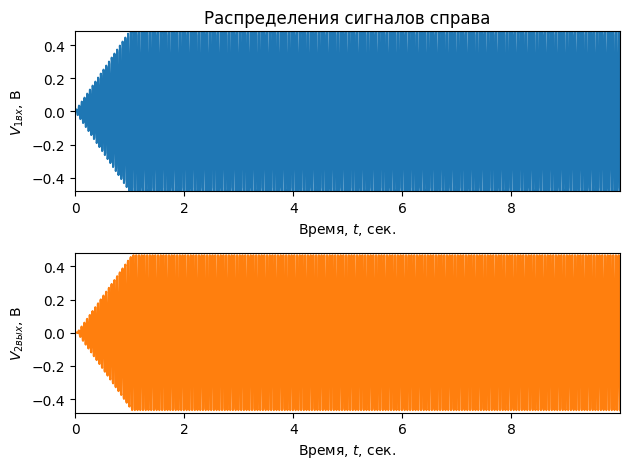

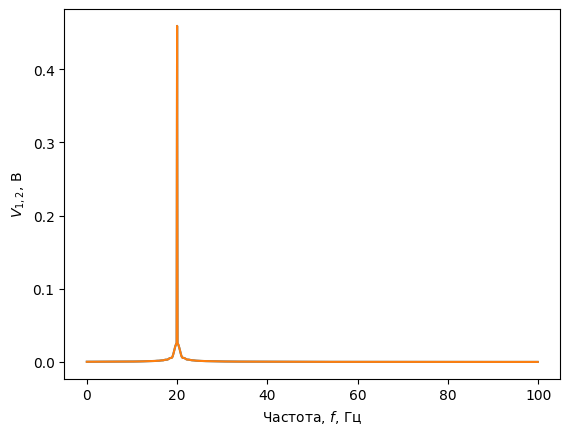

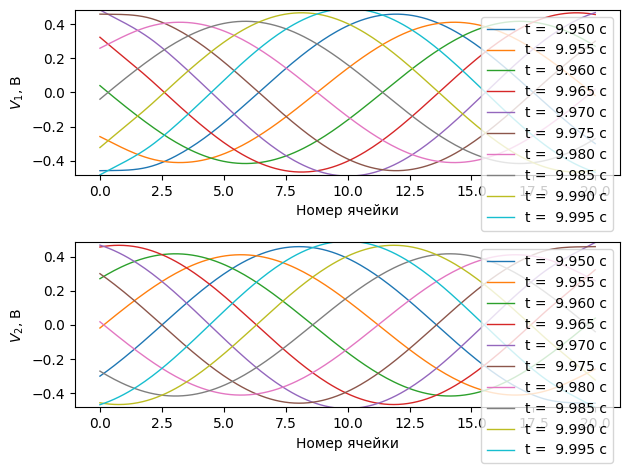

  0.000  -0.458  -0.300 
  0.500  -0.833  -0.465 
  1.000  -1.143  -0.499 
  1.500  -1.204  -0.452 
  2.000  -1.242  -0.413 
  2.500  -1.267  -0.388 
  3.000  -1.283  -0.373 
  3.500  -1.293  -0.362 
  4.000  -1.300  -0.356 
  4.500  -1.304  -0.352 
  5.000  -1.307  -0.349 
  5.500  -1.308  -0.347 
  6.000  -1.309  -0.346 
  6.500  -1.310  -0.346 
  7.000  -1.310  -0.345 
  7.500  -1.311  -0.345 
  8.000  -1.311  -0.345 
  8.500  -1.311  -0.345 
  9.000  -1.311  -0.345 
  9.500  -1.311  -0.344 


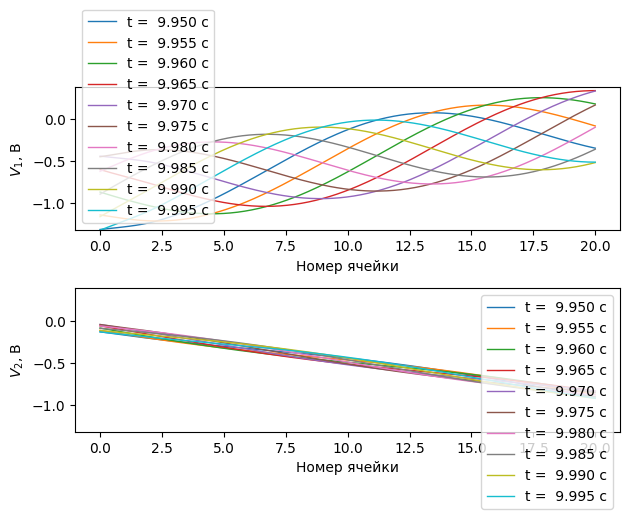

In [ ]:
pulse_1 = False  # False - гармонический сигнал True - ШП импульс для абонента 1 (слева)
pulse_2 = False   # False - гармонический сигнал True - ШП импульс для абонента 2 (справа)
one_ds = False  # Одна РДС (слева), иначе РДС слева и справа

fc1 = 20  # Частота сигнала левого абонента
fc2 = fc1  # Частота сигнала правого абонента
Tc = float(input('Временной интервал '))

fl = 1  # float(input('Нижняя граничная частота ЛП '))
fh = 100  # float(input('Верхняя граничная частота ЛП '))
f0 = (fc1 + fc2) * 0.5  # (fl + fh) * 0.5
Z0 = float(input('Характеристическое сопротивление одного звена ЛП на частоте ' + str(f0) + ' '))
Nc = int(input('Число ячеек в ЛП '))
Ha = float(input('Параметр неравноплечности РУ '))

A12 = 20 * log10(1.0 + 1.0 / Ha)
A14 = 20 * log10(1.0 + Ha)

L = (sqrt(Z0 ** 2 * f2w(f0) ** 2 * (2 * f2w(fh) ** 2 - f2w(fl) ** 2 - f2w(f0) ** 2) /
          ((f2w(fh) ** 2 - f2w(fl) ** 2) ** 2 * (f2w(f0) ** 2 - f2w(fl) ** 2))))
C1 = 1.0 / L / (f2w(fh) ** 2 - f2w(fl) ** 2)
C2 = 1.0 / (f2w(fl) ** 2 * L)
G = 0

print('Параметры отдельной ячейки ЛП:')
print('C1 = {0: f}\nC2 = {1: f}\nL = {2: f}'.format(C1, C2, L))
print('Затухание в направлении передачи: {0: 5.2f} дБ - {1: 5.2f}'.format(A12, 10 ** (0.05 * A12)))
print('Затухание в направлении приема: {0: 5.2f} дБ - {1: 5.2f}'.format(A14, 10 ** (0.05 * A14)))

npp = 10  # Количество точек на период гармонического сигнала
dt = 1 / (max(fc1, fc2) * npp)  # Шаг по времени
num = int(Tc / dt)  # Количество временных отсчетов

freq = np.linspace(0.8 * fl, fh * 1.2, num)

A0 = 1  # Амплитуда сигнала в направлении слева направо
AN = 1  # Амплитуда сигнала в направлении справа налево
K0 = KN = 1  # Коэффициенты при нагрузочных сопротивлениях

# Количество итераций для решения уравнений возбуждения
dpp = 20
print('dpp = {0: d}'.format(dpp))

aU_1 = [0] * Nc  # Массив напряжений на емкости C2
aU_2 = [0] * Nc  # Массив напряжений на емкости C2
dU_1 = [0] * Nc  # Массив производных напряжений на емкости C2
dU_2 = [0] * Nc  # Массив производных напряжений на емкости C2
aV_1 = [0] * (Nc + 1)  # Массив напряжений на емкости C1
aV_2 = [0] * (Nc + 1)  # Массив напряжений на емкости C1
dV_1 = [0] * (Nc + 1)  # Массив производных напряжений на емкости C1
dV_2 = [0] * (Nc + 1)  # Массив производных напряжений на емкости C1

Vinp_1 = [0] * num  # Массив входных напряжений
Vinp_2 = [0] * num  # Массив входных напряжений
Vout_1 = [0] * num  # Массив выходных напряжений
Vout_2 = [0] * num  # Массив выходных напряжений
time = [0] * num  # Массив временных отсчетов

Vs_1 = [0] * npp  # Массив напряжений на C1 вдоль ЛП на одном периоде сигнала
Vs_2 = [0] * npp  # Массив напряжений на C1 вдоль ЛП на одном периоде сигнала
for i in range(npp):
    Vs_1[i] = [0] * (Nc + 1)
    Vs_2[i] = [0] * (Nc + 1)

vmax = vmin = 0
# Решение уравнений возбуждения ЛП
for it in range(num):
    time[it] = dt * it
    for i in range(dpp):
        dE0_1 = A0 / (10 ** (0.05 * A12)) * (d_wb_pulse(time[it], 10, 20) if pulse_1 else d_signal1(time[it]))
        dE0_2 = A0 / (10 ** (0.05 * A14)) * (d_wb_pulse(time[it], 10, 20) if pulse_1 else d_signal1(time[it]))
        dV_1[0] += (1.0 / (L * C1) * (aV_1[1] - aV_1[0] + aU_1[0]) + 1.0 / (Z0 * K0 * C1) * (
                    dE0_1 - dV_1[0])) * dt / dpp
        dV_2[0] += (1.0 / (L * C1) * (aV_2[1] - aV_2[0] + aU_2[0]) + 1.0 / (Z0 * K0 * C1) * (
                    dE0_2 - dV_2[0])) * dt / dpp
        for ic in range(Nc):
            dU_1[ic] += (1.0 / (L * C2) * (aV_1[ic] - aV_1[ic + 1] - aU_1[ic]) - G / C2 * dU_1[ic]) * dt / dpp
            dU_2[ic] += (1.0 / (L * C2) * (aV_2[ic] - aV_2[ic + 1] - aU_2[ic]) - G / C2 * dU_2[ic]) * dt / dpp
            if ic == 0: continue
            dV_1[ic] += (0.5 / (L * C1) * (
                        aV_1[ic - 1] - 2.0 * aV_1[ic] + aV_1[ic + 1] + aU_1[ic] - aU_1[ic - 1])) * dt / dpp
            dV_2[ic] += (0.5 / (L * C1) * (
                        aV_2[ic - 1] - 2.0 * aV_2[ic] + aV_2[ic + 1] + aU_2[ic] - aU_2[ic - 1])) * dt / dpp
        dEN_1 = 0 if one_ds else AN / (10 ** (0.05 * A14)) * (
            d_wb_pulse(time[it], 12, 22) if pulse_2 else d_signal2(time[it]))
        dEN_2 = 0 if one_ds else AN / (10 ** (0.05 * A12)) * (
            d_wb_pulse(time[it], 12, 22) if pulse_2 else d_signal2(time[it]))
        dV_1[Nc] += (1.0 / (L * C1) * (aV_1[Nc - 1] - aV_1[Nc] - aU_1[Nc - 1]) + 1.0 / (Z0 * KN * C1) * (
                    dEN_1 - dV_1[Nc])) * dt / dpp
        dV_2[Nc] += (1.0 / (L * C1) * (aV_2[Nc - 1] - aV_2[Nc] - aU_2[Nc - 1]) + 1.0 / (Z0 * KN * C1) * (
                    dEN_2 - dV_2[Nc])) * dt / dpp

        for ic in range(Nc):
            aV_1[ic] += dV_1[ic] * dt / dpp
            aV_2[ic] += dV_2[ic] * dt / dpp
            aU_1[ic] += dU_1[ic] * dt / dpp
            aU_2[ic] += dU_2[ic] * dt / dpp
        aV_1[Nc] += dV_1[Nc] * dt / dpp
        aV_2[Nc] += dV_2[Nc] * dt / dpp

    if num - it <= npp:
        for ic in range(Nc + 1):
            Vs_1[it - (num - npp)][ic] = aV_1[ic]
            Vs_2[it - (num - npp)][ic] = aV_2[ic]

    Vinp_1[it] = aV_1[0]
    Vout_1[it] = aV_1[Nc]
    Vinp_2[it] = aV_2[Nc]
    Vout_2[it] = aV_2[0]
    npr = 10 ** int(log10(num)) / 10
    if it % npr == 0:
        print('{0: 7.3f} {1: 7.3f} {2: 7.3f} '.format(time[it], Vinp_1[it], Vout_1[it]))

# Расчет спектра сигалов слева и справа
spectr_inp_1 = np.fft.fft(Vinp_1)
spectr_out_1 = np.fft.fft(Vout_1)
spectr_inp_2 = np.fft.fft(Vinp_2)
spectr_out_2 = np.fft.fft(Vout_2)
fft_freq = np.fft.fftfreq(num, Tc / num)

vmin = min(min(Vinp_1), min(Vinp_2), min(Vout_1), min(Vout_2))
vmax = max(max(Vinp_1), max(Vinp_2), max(Vout_1), max(Vout_2))

fig, (ax0, ax1) = plt.subplots(nrows=2)
ax0.set_title('Распределения сигналов справа')
ax0.plot(time, Vinp_1, 'tab:blue')
ax0.set_xlim(time[0], time[-1])
ax0.set_ylim(vmin, vmax)
ax0.set_xlabel("Время, $t$, сек.", fontsize=10)
ax0.set_ylabel("$V_{1 вх}$, В", fontsize=10)
ax1.plot(time, Vout_2, 'tab:orange')
ax1.set_xlim(time[0], time[-1])
ax1.set_ylim(vmin, vmax)
ax1.set_xlabel("Время, $t$, сек.", fontsize=10)
ax1.set_ylabel("$V_{2 вых}$, В", fontsize=10)
fig.tight_layout()

sp_inp = np.abs(spectr_out_1) / num * 2
sp_out = np.abs(spectr_out_2) / num * 2
fig, ax = plt.subplots()
ax.plot(fft_freq[0:num // 2], sp_inp[0:num // 2], label='$V_1$')
ax.plot(fft_freq[0:num // 2], sp_out[0:num // 2], label='$V_2$')
ax.set_xlabel("Частота, $f$, Гц", fontsize=10)
ax.set_ylabel("$V_{1, 2}$, В", fontsize=10)

cells = np.linspace(0, Nc, Nc + 1)
z_spl = np.linspace(0, Nc, (Nc + 1) * 10)
if not pulse_1 and not pulse_2:
    fig, (ax0, ax1) = plt.subplots(nrows=2)
    for i in range(npp):
        spl = make_interp_spline(cells, Vs_1[i], k=3)
        ax0.plot(z_spl, spl(z_spl), label="t = {0: .3f} с".format(time[num - npp + i]), lw=1)
    ax0.legend(loc='best')
    ax0.set_ylim(vmin, vmax)
    ax0.set_xlabel("Номер ячейки", fontsize=10)
    ax0.set_ylabel("$V_1$, В", fontsize=10)
    for i in range(npp):
        spl = make_interp_spline(cells, Vs_2[i], k=3)
        ax1.plot(z_spl, spl(z_spl), label="t = {0: .3f} с".format(time[num - npp + i]), lw=1)
    ax1.legend(loc='best')
    ax1.set_ylim(vmin, vmax)
    ax1.set_xlabel("Номер ячейки", fontsize=10)
    ax1.set_ylabel("$V_2$, В", fontsize=10)
fig.tight_layout()

plt.show()

one_ds = True

for it in range(num):
    time[it] = dt * it
    for i in range(dpp):
        dE0_1 = A0 / (10 ** (0.05 * A12)) * (d_wb_pulse(time[it], 10, 20) if pulse_1 else d_signal1(time[it]))
        dE0_2 = A0 / (10 ** (0.05 * A14)) * (d_wb_pulse(time[it], 10, 20) if pulse_1 else d_signal1(time[it]))
        dV_1[0] += (1.0 / (L * C1) * (aV_1[1] - aV_1[0] + aU_1[0]) + 1.0 / (Z0 * K0 * C1) * (
                    dE0_1 - dV_1[0])) * dt / dpp
        dV_2[0] += (1.0 / (L * C1) * (aV_2[1] - aV_2[0] + aU_2[0]) + 1.0 / (Z0 * K0 * C1) * (
                    dE0_2 - dV_2[0])) * dt / dpp
        for ic in range(Nc):
            dU_1[ic] += (1.0 / (L * C2) * (aV_1[ic] - aV_1[ic + 1] - aU_1[ic]) - G / C2 * dU_1[ic]) * dt / dpp
            dU_2[ic] += (1.0 / (L * C2) * (aV_2[ic] - aV_2[ic + 1] - aU_2[ic]) - G / C2 * dU_2[ic]) * dt / dpp
            if ic == 0: continue
            dV_1[ic] += (0.5 / (L * C1) * (
                        aV_1[ic - 1] - 2.0 * aV_1[ic] + aV_1[ic + 1] + aU_1[ic] - aU_1[ic - 1])) * dt / dpp
            dV_2[ic] += (0.5 / (L * C1) * (
                        aV_2[ic - 1] - 2.0 * aV_2[ic] + aV_2[ic + 1] + aU_2[ic] - aU_2[ic - 1])) * dt / dpp
        dEN_1 = 0 if one_ds else AN / (10 ** (0.05 * A14)) * (
            d_wb_pulse(time[it], 12, 22) if pulse_2 else d_signal2(time[it]))
        dEN_2 = 0 if one_ds else AN / (10 ** (0.05 * A12)) * (
            d_wb_pulse(time[it], 12, 22) if pulse_2 else d_signal2(time[it]))
        dV_1[Nc] += (1.0 / (L * C1) * (aV_1[Nc - 1] - aV_1[Nc] - aU_1[Nc - 1]) + 1.0 / (Z0 * KN * C1) * (
                    dEN_1 - dV_1[Nc])) * dt / dpp
        dV_2[Nc] += (1.0 / (L * C1) * (aV_2[Nc - 1] - aV_2[Nc] - aU_2[Nc - 1]) + 1.0 / (Z0 * KN * C1) * (
                    dEN_2 - dV_2[Nc])) * dt / dpp

        for ic in range(Nc):
            aV_1[ic] += dV_1[ic] * dt / dpp
            aV_2[ic] += dV_2[ic] * dt / dpp
            aU_1[ic] += dU_1[ic] * dt / dpp
            aU_2[ic] += dU_2[ic] * dt / dpp
        aV_1[Nc] += dV_1[Nc] * dt / dpp
        aV_2[Nc] += dV_2[Nc] * dt / dpp

    if num - it <= npp:
        for ic in range(Nc + 1):
            Vs_1[it - (num - npp)][ic] = aV_1[ic]
            Vs_2[it - (num - npp)][ic] = aV_2[ic]

    Vinp_1[it] = aV_1[0]
    Vout_1[it] = aV_1[Nc]
    Vinp_2[it] = aV_2[Nc]
    Vout_2[it] = aV_2[0]
    npr = 10 ** int(log10(num)) / 10
    if it % npr == 0:
        print('{0: 7.3f} {1: 7.3f} {2: 7.3f} '.format(time[it], Vinp_1[it], Vout_1[it]))

# Расчет спектра сигалов слева и справа
spectr_inp_1 = np.fft.fft(Vinp_1)
spectr_out_1 = np.fft.fft(Vout_1)
spectr_inp_2 = np.fft.fft(Vinp_2)
spectr_out_2 = np.fft.fft(Vout_2)
fft_freq = np.fft.fftfreq(num, Tc / num)

vmin = min(min(Vinp_1), min(Vinp_2), min(Vout_1), min(Vout_2))
vmax = max(max(Vinp_1), max(Vinp_2), max(Vout_1), max(Vout_2))

# fig, (ax0, ax1) = plt.subplots(nrows=2)
# ax0.set_title('Распределения сигналов справа')
# ax0.plot(time, Vinp_1, 'tab:blue')
# ax0.set_xlim(time[0], time[-1])
# ax0.set_ylim(vmin, vmax)
# ax0.set_xlabel("Время, $t$, сек.", fontsize=10)
# ax0.set_ylabel("$V_{1 вх}$, В", fontsize=10)
# ax1.plot(time, Vout_2, 'tab:orange')
# ax1.set_xlim(time[0], time[-1])
# ax1.set_ylim(vmin, vmax)
# ax1.set_xlabel("Время, $t$, сек.", fontsize=10)
# ax1.set_ylabel("$V_{2 вых}$, В", fontsize=10)
# fig.tight_layout()

sp_inp = np.abs(spectr_out_1) / num * 2
sp_out = np.abs(spectr_out_2) / num * 2
# fig, ax = plt.subplots()
# ax.plot(fft_freq[0:num // 2], sp_inp[0:num // 2], label='$V_1$')
# ax.plot(fft_freq[0:num // 2], sp_out[0:num // 2], label='$V_2$')
# ax.set_xlabel("Частота, $f$, Гц", fontsize=10)
# ax.set_ylabel("$V_{1, 2}$, В", fontsize=10)

cells = np.linspace(0, Nc, Nc + 1)
z_spl = np.linspace(0, Nc, (Nc + 1) * 10)
if not pulse_1 and not pulse_2:
    fig, (ax0, ax1) = plt.subplots(nrows=2)
    for i in range(npp):
        spl = make_interp_spline(cells, Vs_1[i], k=3)
        ax0.plot(z_spl, spl(z_spl), label="t = {0: .3f} с".format(time[num - npp + i]), lw=1)
    ax0.legend(loc='best')
    ax0.set_ylim(vmin, vmax)
    ax0.set_xlabel("Номер ячейки", fontsize=10)
    ax0.set_ylabel("$V_1$, В", fontsize=10)
    for i in range(npp):
        spl = make_interp_spline(cells, Vs_2[i], k=3)
        ax1.plot(z_spl, spl(z_spl), label="t = {0: .3f} с".format(time[num - npp + i]), lw=1)
    ax1.legend(loc='best')
    ax1.set_ylim(vmin, vmax)
    ax1.set_xlabel("Номер ячейки", fontsize=10)
    ax1.set_ylabel("$V_2$, В", fontsize=10)
fig.tight_layout()

plt.show()

In [ ]:
!jupyter nbconvert --to html '/content/Описис_сем_12.ipynb'

[NbConvertApp] Converting notebook /content/Описис_сем_12.ipynb to html
[NbConvertApp] Writing 1566968 bytes to /content/Описис_сем_12.html
